In [21]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import re


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [22]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [23]:
k = 10 # Top 10% highest l2-magnitude filters

In [24]:
ax[0, 0].collections[1]

 ============ LAYER 0 ==================
[9, 18, 55, 36, 32, 20, 63, 11, 44, 59]
(7, 7, 3, 10)
(10, 7, 7, 3) (10, 7, 7, 3) (10, 7, 7, 3)
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[0.00271316 0.0529143 ] [[-0.07700618 -0.99703062]
 [-0.99703062  0.07700618]]
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[0.08740656 0.78223182] [[-0.9393016  -0.34309257]
 [-0.34309257  0.9393016 ]]
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[0.00288611 0.09200946] [[-0.04406672 -0.99902859]
 [-0.99902859  0.04406672]]
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[0.01831894 1.16850083] [[-0.72518732 -0.68855163]
 [-0.68855163  0.72518732]]
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[0.00784812 0.07975935] [[-0.69125743 -0.72260859]
 [-0.72260859  0.69125743]]
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[0.00086334 0.09934472] [[-0.00443206 -0.99999018]
 [-0.99999018  0.00443206]]
(1, 7, 7, 3) (1, 7, 7, 3) (1, 7, 7, 3)
[1.03256193e-04 1.30250814e-01] [[-0.98862059 -0.15043051]
 [-0.15043051  0.98862059]]
(1, 7, 7, 3) (1, 7, 7, 3) (1,

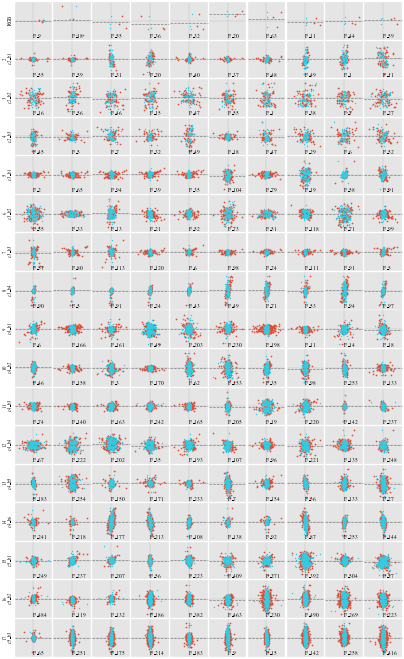

In [25]:

#plt.style.use(['ggplot'])
plt.rcParams.update({'figure.dpi': '50'})

conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (7, 7) or l.kernel_size == (3,3):
			conv_layers.append(l)
e_beta = []
beta = []
min_beta = []
max_beta = []


plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
fig= plt.figure(figsize = (10,len(conv_layers)))
fig.clf()

#fig.tight_layout()
gs1 = gridspec.GridSpec(len(conv_layers), 10)
gs1.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 
ax = [fig.add_subplot(ss) for ss in gs1]
ax = np.reshape(ax, (len(conv_layers), 10))
#fig, ax = plt.subplots(gs1 , sharex=False, sharey=False)



#fig.set_tight_layout(True)
for l_num, l in enumerate(conv_layers):
	print(f" ============ LAYER {l_num} ==================")
	top10F=topKfilters(model, l_num, k=100, sev=True)[:10]
	print(top10F[:10])
	filters = get_filter(model, l_num, sev=True)[:,:,:, top10F]
	theta = getSobelTF(filters)
	print(filters.shape)
	s, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a, axis=[0,1])
	s_mag = reduce_euclidean_norm(s, axis=[0,1])
	dc = np.sign(reduce_mean(s, axis=[0,1]))


	for i in range(10):
		
		x =a_mag[:,i]*np.cos((theta[:,i]))
		y = a_mag[:,i]*np.sin((theta[:,i]))
		#c,s = mean_direction(theta[:,i], a_mag[:,i])
		#print(d)


		dvec, dtheta = getDominantAngle(tf.expand_dims(filters[:,:, :,i], -1))

		#c,s = mean_direction(theta[:,i], a_mag[:,i])
		#print(d)
		lim_x = np.max(np.abs(a_mag[:,i]))
		lim_y = np.max(np.abs( s_mag[:,i]))
		lim = np.max([lim_x, lim_y])
		lim *= 1.3

		e_vec1 = dvec[0]  #Major
		e_vec2 = [-e_vec1[1], e_vec1[0]]

		fa1 = tf.tensordot(tf.stack([x,y], axis=1) , e_vec1, axes=1) / tf.math.reduce_euclidean_norm(e_vec1) #filter projected onto Major Axis
		fa2 = tf.tensordot(tf.stack([x,y], axis=1) , e_vec2, axes=1) / tf.math.reduce_euclidean_norm(e_vec2) #filter projected onto Minor Axis

		#ax[l_num, i] = fig.add_subplot(gs1[l_num,i])
		ax[l_num, i].set_xlim(-lim, lim)
		ax[l_num, i].set_ylim(-lim, lim)

		'''ax[l_num, i].spines['right'].set_position('center')
		ax[l_num, i].spines['bottom'].set_position('center')

		# Eliminate upper and right axes
		ax[l_num, i].spines['left'].set_color('none')
		ax[l_num, i].spines['top'].set_color('none')

		# Show ticks in the left and lower axes only
		ax[l_num, i].xaxis.set_ticks_position('bottom')
		ax[l_num, i].yaxis.set_ticks_position('left')'''


		ax[l_num, i].axhline(0, color='black', clip_on=False, zorder=-2,linewidth=-.1)
		ax[l_num, i].axvline(0, color='black', clip_on=False, zorder=-2,linewidth=-.1)

		ax[l_num, i].scatter(fa1, s_mag[:,i]*dc[:,i], s=2, color='#E24A33', clip_on=False)
		ax[l_num, i].scatter(fa2, s_mag[:,i]*dc[:,i], s=1, color='#33CBE2', clip_on=False)

		ax[l_num, i].axhline(np.mean(s_mag[:,i]*dc[:,i]), color='gray', clip_on=False, linestyle='--',zorder=-1)


		ax[l_num, i].text(0.5,0.15, f"F_{top10F[i]}", transform=ax[l_num, i].transAxes, va='top')

		ax[l_num, i].set_box_aspect(1)

		ax[l_num, i].set_xticks([])
		ax[l_num, i].set_yticks([])
		ax[l_num, i].set_aspect('equal')
		ax[l_num, i].collections[0].set_rasterized(True)
		ax[l_num, i].collections[1].set_rasterized(True)


		#ax[l_num, i].arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
		#ax[l_num, i].arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")

		#ax[l_num, i].set_title(f"{c:.2f}, {s:.2f}")
for i, l_num in enumerate(conv_layers):

	#print(conv_layers[0].name)
	match = re.search(r"conv(\d+)_block(\d+)", conv_layers[i].name)
	if match is None:
		match = re.search(r"conv(\d+)_conv", conv_layers[i].name)
		ax[i, 0].set_ylabel(f"RGB", fontsize=7) 
		continue

	ax[i, 0].set_ylabel(f"{i+1}\nc{match.group(1)}_b{match.group(2)}", fontsize=7) 

#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)




In [26]:
fig.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()

In [27]:
fig.savefig('resnet_sym_antisym.pdf', dpi=200)
plt.show()